In [26]:
import sys
sys.path.append(r'C:\Users\Han lab\Documents\MATLAB\han-lab') ## custom your clone
import preprocessing
from kmeans import collect_clustering_vars, run_pca, run_kmeans
#analyze videos and copy vr files before this step

import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

In [27]:
vrfl = r'X:\PupilTraining-Matt-2023-07-07\videos\e189_18_May_2023_time(10_32_42).mat'

In [28]:
dlccsv = r'X:\PupilTraining-Matt-2023-07-07\videos\230518_E189DLC_resnet50_PupilTrainingJul7shuffle1_700000_filtered.csv'

In [29]:
preprocessing.VRalign(vrfl,dlccsv)

X:\PupilTraining-Matt-2023-07-07\videos\e189_18_May_2023_vr_dlc_align.p


In [30]:
dfpth = dlccsv

In [31]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np, seaborn as sns
import os, cv2
import scipy.ndimage
import pickle
from preprocessing import fixcsvcols
from PIL import Image, ImageDraw
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

In [32]:
matfl = r"X:\PupilTraining-Matt-2023-07-07\videos\e189_18_May_2023_vr_dlc_align.p"

In [33]:
df = pd.read_csv(dfpth)
# if 'bodyparts' not in df.columns: ## this was missing some dfs

try:  
    df = fixcsvcols(dfpth)
except Exception as e:
    print(e)

if "Unnamed: 0" in df.columns:
    df = df.drop(columns = ["Unnamed: 0"])

with open(matfl,'rb') as fp: #unpickle
    mat = pickle.load(fp)

forwardvelocity = mat['forwardvel']

ufunc 'add' did not contain a loop with signature matching types (dtype('float64'), dtype('<U2')) -> None


In [34]:
mat

{'experiment': 'M3_M4_altered_dim_HRZ_double_probe_middle_5cmRL_GM_sol2',
 'ybinned': array([[  1.5       ],
        [  1.5       ],
        [  1.5       ],
        ...,
        [152.71617933],
        [152.70751267],
        [         nan]]),
 'rewards': array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]),
 'forwardvel': array([[36.89137291],
        [30.84882045],
        [32.75699491],
        ...,
        [-0.31802908],
        [ 0.        ],
        [        nan]]),
 'licks': array([[   0.],
        [   0.],
        [   0.],
        ...,
        [   0.],
        [   0.],
        [5679.]]),
 'changeRewLoc': array([[144.],
        [  0.],
        [  0.],
        ...,
        [  0.],
        [  0.],
        [  0.]]),
 'trialnum': array([[16.],
        [16.],
        [16.],
        ...,
        [16.],
        [16.],
        [16.]]),
 'timedFF': array([[0.00000000e+00],
        [3.22877952e-02],
        [6.45755903e-02],
        ...,
       

In [35]:
idx = len(df) - 1 if len(df) % 2 else len(df)
df = df[:idx].groupby(df.index[:idx] // 2).mean()
poses = df.columns[1:]
eye = ['EyeNorth', 'EyeNorthWest', 'EyeWest', 'EyeSouthWest', 
        'EyeSouth', 'EyeSouthEast', 'EyeEast', 'EyeNorthEast']
eyelid = ['EyeLidNorthWest', 'EyeLidSouthWest', 'EyeLidSouth', 'EyeLidEast', 'EyeLidNorth']

In [36]:

def get_eye_features(eye_coords, eyelbl = False):
    # eye coords format = list of (x,y) tuples
    img = Image.new('L', (600, 422), 0) # L is imagetype, 600, 422 is image dim

    ImageDraw.Draw(img).polygon(eye_coords, outline=1, fill=1)
    mask = np.array(img)

    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, 
                        cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    area = cv2.contourArea(cnt)  # Area of first contour
    perimeter = cv2.arcLength(cnt, True)  # Perimeter of first contour 

    return area, perimeter

def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length


In [55]:
#eye centroids, area, perimeter
def area_and_perim(eye):
    centroids_x = []; centroids_y = [];
    areas = []; circumferences = [];
    for i in range(len(df)):
        eye_x = np.array([df[xx+"_x"].iloc[i] for xx in eye])
        eye_y = np.array([df[xx+"_y"].iloc[i] for xx in eye])
        eye_coords = np.array([eye_x, eye_y]).astype(float)
        centroid_x, centroid_y = centeroidnp(eye_coords)
        area, circumference = get_eye_features([(float(df[xx+"_x"].iloc[i]), 
                                float(df[xx+"_y"].iloc[i])) for xx in eye])
        centroids_x.append(centroid_x)
        centroids_y.append(centroid_y)
        areas.append(area); circumferences.append(circumference)
    return (centroids_x, centroids_y, areas, circumferences)

eye_centroid_x, eye_centroid_y, eye_area, eye_circumference = area_and_perim(eye)
eyelid_centroid_x, eyelid_centroid_y, eyelid_area, eyelid_circumference = area_and_perim(eyelid)


In [54]:
eyewest_x = df["EyeWest_x"]
eyewest_y = df["EyeWest_y"]

In [38]:
blinks=scipy.ndimage.gaussian_filter(df['EyeNorth_y'].astype('float32').values - df['EyeSouth_y'].astype('float32').values,sigma=3)
eye_area=scipy.ndimage.gaussian_filter((eye_area),sigma=2)

In [56]:
datadf = [[os.path.basename(matfl)[:4]]*len(blinks), 
          [os.path.basename(matfl)[5:-15]]*len(blinks),
          blinks, eye_centroid_x, eye_centroid_y, eyewest_x, eyewest_y, eye_area, eye_circumference, eyelid_area,
          eyelid_circumference, forwardvelocity, mat['ybinned'], mat['licks'], 
          mat['lickVoltage'], mat['changeRewLoc'],
          [mat['experiment']]*len(blinks)]
datadf = np.array([np.ravel(np.array(xx)) for xx in datadf])
dfpose = pd.DataFrame(datadf.T, columns = ["animal","data",
          "blinks", "eye_centroid_x", "eye_centroid_y", "eye_west_x", "eye_west_y","eye_area", "eye_circumference", 
          "eyelid_area", "eyelid_circumference","forwardvelocity",'ybinned', 'licks', 'lickVoltage',
          'changeRewLoc','experiment'])

In [40]:
blinks[0:10]

array([-43.405384, -43.399868, -43.388992, -43.373028, -43.35248 ,
       -43.328396, -43.302536, -43.277187, -43.25467 , -43.23698 ],
      dtype=float32)

In [57]:
dfpose.to_pickle(r'X:\PupilTraining-Matt-2023-07-07\videos\e189_18_May_2023_dlc_vars.p')

In [58]:
dfpose

,animal,data,blinks,eye_centroid_x,eye_centroid_y,eye_west_x,eye_west_y,eye_area,eye_circumference,eyelid_area,eyelid_circumference,forwardvelocity,ybinned,licks,lickVoltage,changeRewLoc,experiment
0,e189,18_May_2023,-43.405384,53.34334182739258,46.168678283691406,60.202789306640625,42.694129943847656,1773.0,168.85281217098236,3095.0,232.7939372062683,36.891372907197855,1.5,0.0,-0.046554595809909914,144.0,M3_M4_altered_dim_HRZ_double_probe_middle_5cmR...
1,e189,18_May_2023,-43.399868,53.43743705749512,46.40389013290405,60.409284591674805,42.82915496826172,1795.0,170.02438509464264,3099.0,233.62236487865448,30.84882044826027,1.5,0.0,-0.052227480377048045,0.0,M3_M4_altered_dim_HRZ_double_probe_middle_5cmR...
2,e189,18_May_2023,-43.388992,53.43535614013672,46.39628887176514,60.188947677612305,42.789283752441406,1791.0,170.02438473701477,3136.5,235.03657793998718,32.75699490897741,1.5,0.0,-0.052875810040509515,0.0,M3_M4_altered_dim_HRZ_double_probe_middle_5cmR...
3,e189,18_May_2023,-43.373028,53.434635162353516,46.52478790283203,59.978952407836914,42.789283752441406,1823.5,171.43859803676605,3162.0,235.62236440181732,30.2127622946879,1.5,0.0,-0.05238956279383094,0.0,M3_M4_altered_dim_HRZ_double_probe_middle_5cmR...
4,e189,18_May_2023,-43.35248,53.37379837036133,46.61020278930664,59.8490047454834,43.15623474121094,1819.5,171.43859815597534,3137.5,235.03657793998718,29.894733217901706,1.5,0.0,-0.05271372762498376,0.0,M3_M4_altered_dim_HRZ_double_probe_middle_5cmR...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,e189,18_May_2023,-44.015385,52.3457818031311,47.12906837463379,62.51109313964844,40.869972229003906,1667.5,163.4385985136032,2699.0,219.137082695961,0.6360581535723768,152.7075126666666,0.0,-0.04914791447652344,0.0,M3_M4_altered_dim_HRZ_double_probe_middle_5cmR...
54996,e189,18_May_2023,-44.01041,52.39068269729614,47.05885410308838,62.51109313964844,40.75436210632324,1676.0,163.6812391281128,2699.0,219.137082695961,0.0,152.71617933333326,0.0,-0.047527090310402226,0.0,M3_M4_altered_dim_HRZ_double_probe_middle_5cmR...
54997,e189,18_May_2023,-44.000168,52.45491409301758,47.13729190826416,62.36974334716797,40.72376251220703,1693.5,164.26702558994293,2701.0,219.137082695961,-0.3180290767861884,152.71617933333326,0.0,-0.054496634198388676,0.0,M3_M4_altered_dim_HRZ_double_probe_middle_5cmR...
54998,e189,18_May_2023,-43.98843,52.59808349609375,47.20275115966797,62.494876861572266,41.06097984313965,1628.5,161.4385985136032,2699.0,219.137082695961,0.0,152.7075126666666,0.0,-0.06081784842243506,0.0,M3_M4_altered_dim_HRZ_double_probe_middle_5cmR...


In [43]:
%matplotlib inline

In [44]:
dfpose.eye_area

0        1789.4861812310896
1         1792.985171837062
2        1798.0964157298415
3        1802.1069706751036
4        1803.0257094324954
                ...        
54995    1664.7523212718945
54996    1665.9840433672093
54997    1665.0730331508198
54998    1662.8055052134869
54999     1660.977222283703
Name: eye_area, Length: 55000, dtype: object

In [45]:
dfpose.eye_area.values

array(['1789.4861812310896', '1792.985171837062', '1798.0964157298415',
       ..., '1665.0730331508198', '1662.8055052134869',
       '1660.977222283703'], dtype=object)

(1200.0, 2200.0)

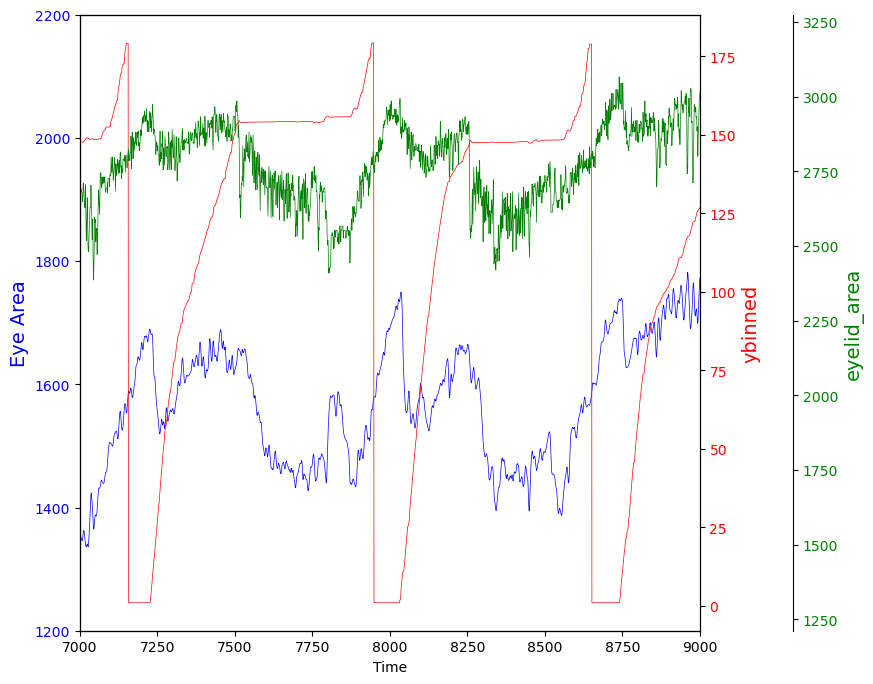

In [46]:
COLOR_EYE_AREA = "blue"
COLOR_YBINNED = "red"
COLOR_eyelid_area = "green"

fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()
ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.15))

ax1.plot(dfpose.eye_area.values.astype(float), color=COLOR_EYE_AREA, lw=0.5)
ax2.plot(dfpose.ybinned.values.astype(float), color=COLOR_YBINNED, lw=0.5)
ax3.plot(dfpose.eyelid_area.values.astype(float), color=COLOR_eyelid_area, lw=0.5)

ax1.set_xlabel("Time")
ax1.set_ylabel("Eye Area", color=COLOR_EYE_AREA, fontsize=14)
ax1.tick_params(axis="y", labelcolor=COLOR_EYE_AREA)

ax2.set_ylabel("ybinned", color=COLOR_YBINNED, fontsize=14)
ax2.tick_params(axis="y", labelcolor=COLOR_YBINNED)

ax3.set_ylabel("eyelid_area", color=COLOR_eyelid_area, fontsize=14)
ax3.tick_params(axis="y", labelcolor=COLOR_eyelid_area)

ax1.set_xlim(7000, 9000)
ax1.set_ylim(1200,2200)

(7000.0, 9000.0)

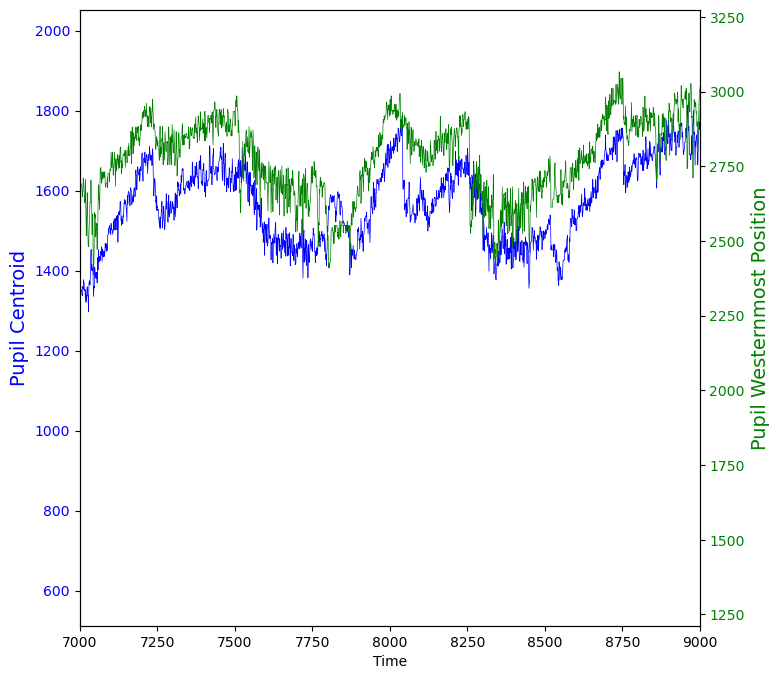

In [63]:
COLOR_EYE_CENTROID_X = "blue"
COLOR_YBINNED = "red"
COLOR_EYE_WEST_X = "green"

fig, ax1 = plt.subplots(figsize=(8, 8))
# ax2 = ax1.twinx()
ax3 = ax1.twinx()

# ax3.spines.right.set_position(("axes", 1.15))

ax1.plot(dfpose.eye_area.values.astype(float), color=COLOR_EYE_CENTROID_X, lw=0.5)
# ax2.plot(dfpose.ybinned.values.astype(float), color=COLOR_YBINNED, lw=0.5)
ax3.plot(dfpose.eyelid_area.values.astype(float), color=COLOR_EYE_WEST_X, lw=0.5)

ax1.set_xlabel("Time")
ax1.set_ylabel("Pupil Centroid", color=COLOR_EYE_CENTROID_X, fontsize=14)
ax1.tick_params(axis="y", labelcolor=COLOR_EYE_CENTROID_X)

# ax2.set_ylabel("Position", color=COLOR_YBINNED, fontsize=14)
# ax2.tick_params(axis="y", labelcolor=COLOR_YBINNED)

ax3.set_ylabel("Pupil Westernmost Position", color=COLOR_EYE_WEST_X, fontsize=14)
ax3.tick_params(axis="y", labelcolor=COLOR_EYE_WEST_X)

ax1.set_xlim(7000, 9000)
# ax1.set_ylim(1200,2200)